# Applications of Convolutional Neural Networks.

## Single-Channel Speech Separation

### Theory

In [192]:
from IPython.display import HTML, Image, display   

### Use-case: Two-Speaker Separation with MiniLibriMix  dataset

The [LibriMix](https://inria.hal.science/hal-03354695/document) dataset consists of two- or three-speaker mixtures combined (or not) with ambient noise samples. 

We'll use a smaller version of it, namely [MiniLibri2Mix](https://zenodo.org/records/3871592), containing 800 mixtures for training and 200 for validation.

In [81]:
import requests, zipfile, io, logging
from tqdm import tqdm

zip_file_url = "https://zenodo.org/records/3871592/files/MiniLibriMix.zip?download=1"

def download_with_progress(url, destination):
    response = requests.get(url, stream=True)
    total_size_in_bytes = int(response.headers.get('content-length', 0))
    block_size = 1024 * 1024 * 10   # 10MB

    with open(destination, 'wb') as file, tqdm(
            desc=destination,
            total=total_size_in_bytes,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(block_size):
            file.write(data)
            bar.update(len(data))

if not os.path.exists("./MiniLibriMix.zip"):
    download_with_progress(zip_file_url, "./MiniLibriMix.zip")

if not os.path.exists("./data/mini_libri2mix"):
    with zipfile.ZipFile("./MiniLibriMix.zip", 'r') as z:
        z.extractall("./data/mini_libri2mix")

#### Define LibriMix Dataset

We'll need a class that can access the MiniLibriMix dataset files and segment each to a given `segment_length`, passed as an argument. This dataset should be able to iterate over all segments, rather than one file at a time: we want in the same batch segments from different files (speakers) !

In [173]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import librosa
from IPython.display import Audio, display
import matplotlib.pyplot as plt


class LibriMixDataset(Dataset):
    def __init__(self, root, subset="train", segment_length=3, typ="clean", sample_rate=8000):
        """
        :param root: string, path to the folder containing MiniLibriMix directory
        :param subset: string, either "train" or "val"
        :param subset: float, the length of each sample in seconds
        :param typ: string, either "clean" for non-noisy mixtures, or "both" which includes the background noise
        """

        self.root = root
        self.subset = subset
        self.typ = typ
        self.sample_rate = sample_rate

        self.seg_len = segment_length * self.sample_rate
        
        assert self.subset in ["train", "val"]
        assert self.typ in ["clean", "both"]

        self.mixtures_path = os.path.join(self.root, 
                                          "MiniLibriMix",
                                          self.subset,
                                          f"mix_{self.typ}",)

        self.metadata_path = os.path.join(self.root, "MiniLibriMix/metadata", f"mixture_{self.subset}_mix_{self.typ}.csv")
        self.metadata = pd.read_csv(self.metadata_path)

        self.segments_per_file = self._segs_per_file()

        # We'll create a list of mixture paths, each one repeated by the number of segments it contains (and the limits for each segment)
        # This will help when indexing the dataset -- we'll know which file to read and from which timestamps to segment
        self.mixtures = []
        for m, k in self.segments_per_file.items():
            for i in range(k):
                self.mixtures.append(
                    (m, i * self.seg_len, (i + 1) * self.seg_len)  # (mixture_path, start_index, end_index)
                )

    def _segs_per_file(self):
        """
        Returns a dictionary with keys : <mixture file path> and values : <#segments per file>.
        This will help in assessing the dataset length (internally used by DataLoader to batch samples) and in constructing the
        mixtures list from which we'll sample given an index (key).
        """
        length_dict = {}
        for index, row in self.metadata.iterrows():
            mixture_path = row['mixture_path']
            length = row['length']
            if length < self.seg_len:
                length_dict[mixture_path] = 1   # we'll pad this with 0s
            else:
                length_dict[mixture_path] = int(length // self.seg_len)
    
        return length_dict

    def __len__(self):
        return sum(list(self.segments_per_file.values()))

    def __getitem__(self, key):
        """
        Retrieves the mixture and sources segments.
        """
        mix_path, sources_path, timestamps = self._get_metadata(key)

        start, end = timestamps
        
        mix, sr = librosa.load(mix_path, sr=self.sample_rate)
        mix = mix[start: end]
        sources = []
        for s_path in sources_path:
            source, sr = librosa.load(s_path, sr=self.sample_rate)
            source = source[start: end]
            sources.append(source)
        
        return mix, sources

    def listen_samples(self, key):
        """
        Retrieves signal paths and plots waveform/audio widget.
        """
        mix_path, sources_path, timestamps = self._get_metadata(key)
        
        start, end = timestamps
        
        audio_files = [mix_path] + sources_path
        audio_titles = ['Mix', 'Source 1', 'Source 2']
        
        audio_widget_groups = []
        for audio_file, title in zip(audio_files, audio_titles):
            
            # Load the audio file and extract the signal and sampling rate
            signal, sr = librosa.load(audio_file, sr=self.sample_rate)

            signal = signal[start: end]
            # Plot the waveform
            plt.figure(figsize=(20, 2))
            librosa.display.waveshow(signal, sr=self.sample_rate)
            plt.title(title)
            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude')
            plt.ylim([-1, 1])
            plt.show()
            
            # Display the audio player
            display(Audio(data=signal, autoplay=False, rate=self.sample_rate))
    
    def _get_metadata(self, key):
        """
        Retrieves the paths for one element of the dataset:
            - mixture
            - source 1
            - source 2

        And returns these paths along with the start-end timestamps
        """
        
        mixture_path, start, end = self.mixtures[key]

        row = self.metadata[self.metadata["mixture_path"] == mixture_path]
        s1_path = row["source_1_path"].values[0]
        s2_path = row["source_2_path"].values[0]

        mixture_path = os.path.join(self.root, mixture_path)
        s1_path = os.path.join(self.root, s1_path)
        s2_path = os.path.join(self.root, s2_path)
        
        return mixture_path, [s1_path, s2_path], (start, end)

In [180]:
segment_length = 3
sr = 8000

train_ds = LibriMixDataset(root="./data/mini_libri2mix/", 
                           subset="train", 
                           segment_length=segment_length, 
                           typ="clean", 
                           sample_rate=sr)

val_ds = LibriMixDataset(root="./data/mini_libri2mix/", 
                         subset="val", 
                         segment_length=segment_length, 
                         typ="clean", 
                         sample_rate=sr)

In [181]:
print(f"#train samples: {len(train_ds)} \t #val_samples: {len(val_ds)}")

#train samples: 2499 	 #val_samples: 277


('./data/mini_libri2mix/MiniLibriMix/train/mix_clean/7335-290365-0050_512-124520-0040.wav', ['./data/mini_libri2mix/MiniLibriMix/train/s1/7335-290365-0050_512-124520-0040.wav', './data/mini_libri2mix/MiniLibriMix/train/s2/7335-290365-0050_512-124520-0040.wav'], (0, 24000))
(24000,)
(24000,)
(24000,)


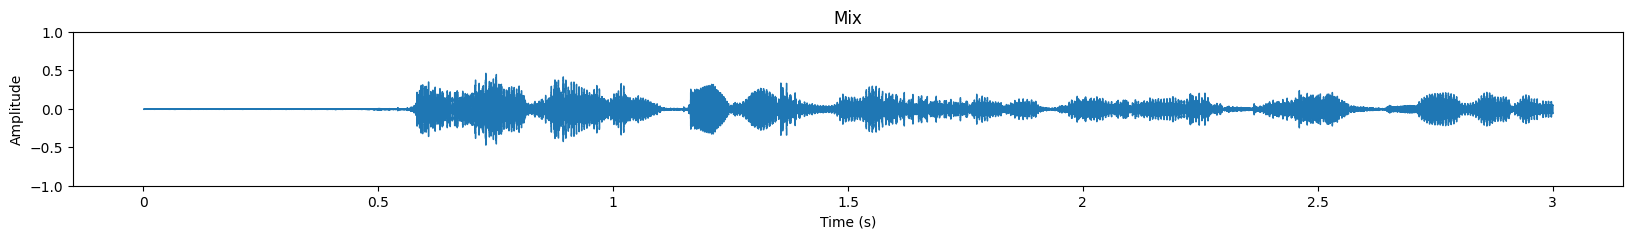

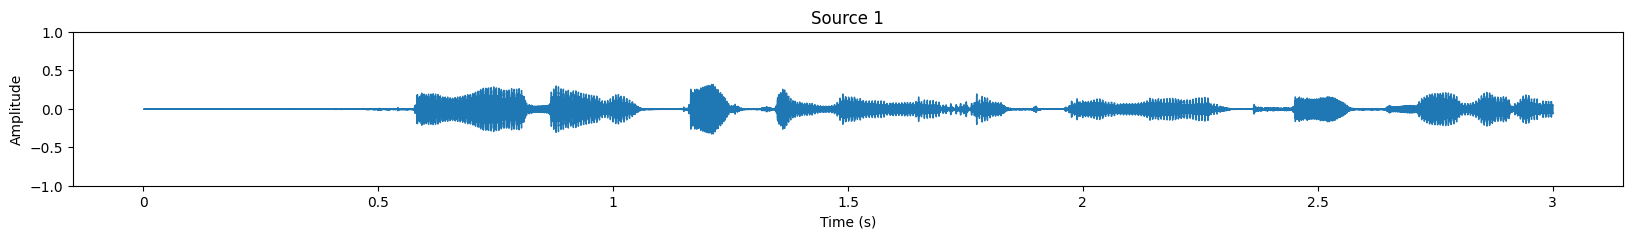

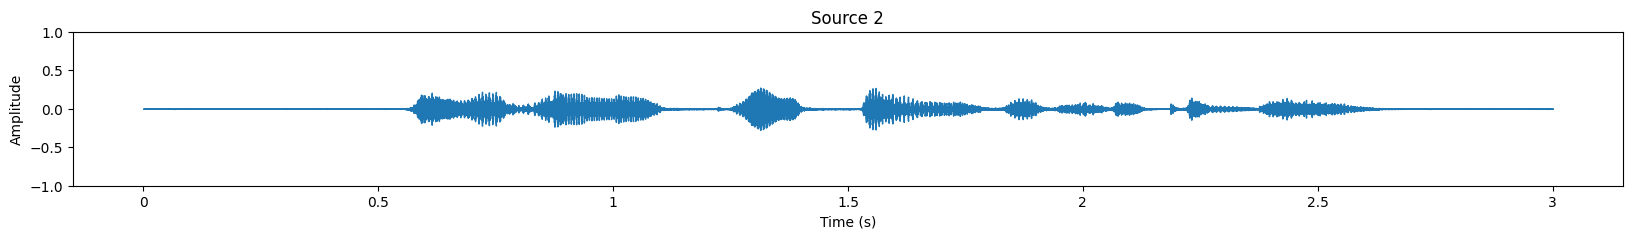

In [218]:
import numpy as np

i = np.random.randint(0, len(train_ds))

print(train_ds._get_metadata(i))

mix, sources = train_ds[i]
print(mix.shape)
for s in sources:
    print(s.shape)

train_ds.listen_samples(i)

#### Conv-TasNet: *Surpassing Ideal Time-Frequency Magnitude Masking for Speech Separation*

We'll use the [Conv-TasNet](https://arxiv.org/pdf/1809.07454v3.pdf) fully-convolutional architecture, using a linear encoder (1D Conv) to map the input mixture to a learned representation, followed by masking the output through a *Temporal Convolutional Network*, and finally retrieving the source signals by inverting the masked representations through a linear decoder (see below).

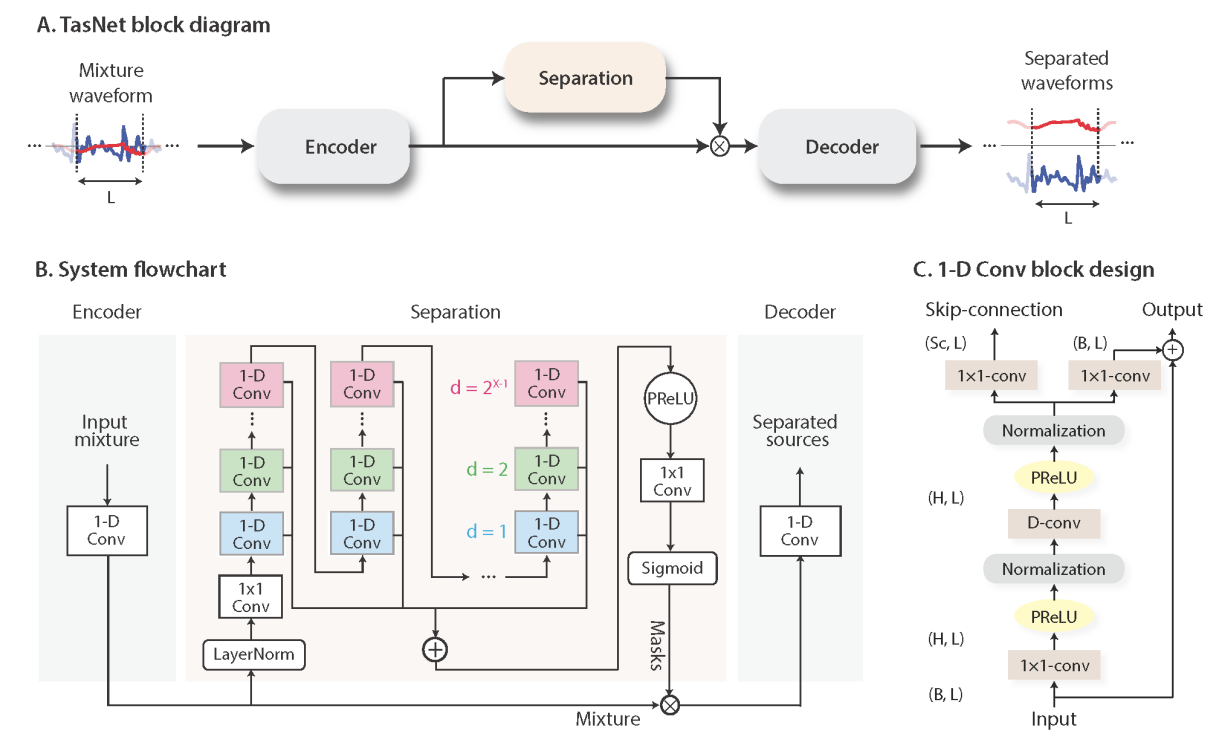

In [193]:
Image("imgs/CONVTASNET.png", width=1000)

[Source](https://arxiv.org/pdf/1809.07454v3.pdf)

Let's break it down:
1. Encoder
    - Tramsforms the input mixture signal using a 1D Conv operation + ReLU
    - The output can be computed as: $y_E = ReLU(W_E \circledast) X$
    - $W_E$ encapsulates the 1D filters of the Encoder, and $X$ is the input mixture signal
2. "Separation"
     - The separation module computes $C$ masks $m_i \in [0, 1]^L$, where $C$ is the number of speakers
     - The representation of each source signal is then computed as: $d_i = y_e \odot m_i$, where $\odot$ denotes element-wise multiplication
     - The constraint $\sum_{i=1}^C m_i = 1$ is aplied during training, assuming the network could perfectly reconstruct the input mixture
     - The separation module conists of multiple stacked 1D Convolution blocks with increasing *dilation rates* -- a lerger dilation rate indicates that a larger temporal context is taken into account for each window of convolution
     - $M$ such convolutional blocks are stacked (with dilation rates $\{1, \dots, 2^{M-1}\}$), and this stacking is repeated $R$ times, with zero-padding applied at the entrance of each block to ensure same output length (to be able to sum up all of them)
3. Decoder
   - The masked representation is brought back to the dimension of the original signal $X$, through *Transposed Convolution* (see below an example)
   - Each masked source representation $d_i$ is transferred to the input domain by: $\hat{s_i} = d_i \circledast^T W_D$


**Dilated Convolution** is a type of convolution where the filter is *widened* with a *dilation factor* $d>1$. For $d=1$ the standard convolution is obtained. 

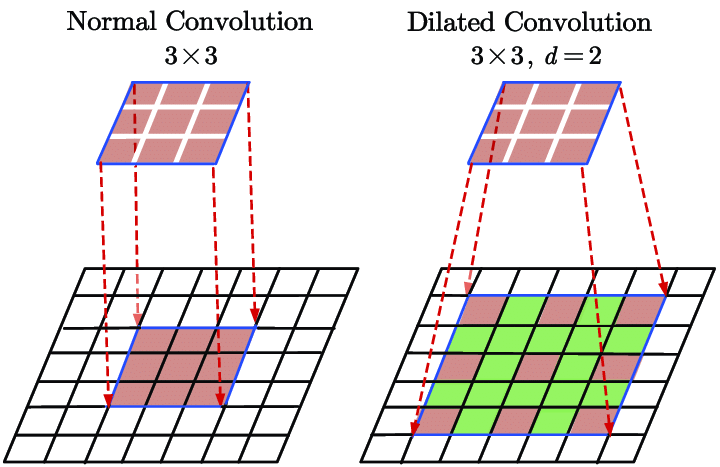

In [196]:
Image("imgs/dilated.png", width=500)

[Source](https://www.researchgate.net/publication/338780378/figure/fig1/AS:850664980742144@1579825744895/The-illustration-of-the-2D-dilated-convolution-with-spatial-size-of-33-and-dilation.png) In the figure above, a dilation factor $d=2$ introduces a zero (a green cells) between two adjacent weights, increasing the effective receptive field from $3\times 3$ to $5\times 5$ -- more generally, for a $k\times k$ kernel and dilation factor $d$ the resulted receptive field becomes $(k + (k-1)(d-1)) \times (k + (k-1)(d-1))$.

This means that for same-sized kernels, an increasing dilation factor $d$ would *"look"* at a bigger area in the input image, at each step. They're useful at extracting multi-scale features, an also very efficient when dealing with very high-resolution images (where small, e.g. $3\times 3$, areas are approximately uniform).

**Transposed Convolution** also known as deconvolution, is a mathematical operation used to increase the spatial/temporal resolution of a signal/internal representation. In a regular convolution, you move the filter over the image, multiply the values of the filter by the corresponding pixel values of the image, and add them together to create a new value. For transposed convolution, instead of moving the filter over the image, you expand the image by inserting empty spaces between its pixels, and then you apply the filter to this expanded image.

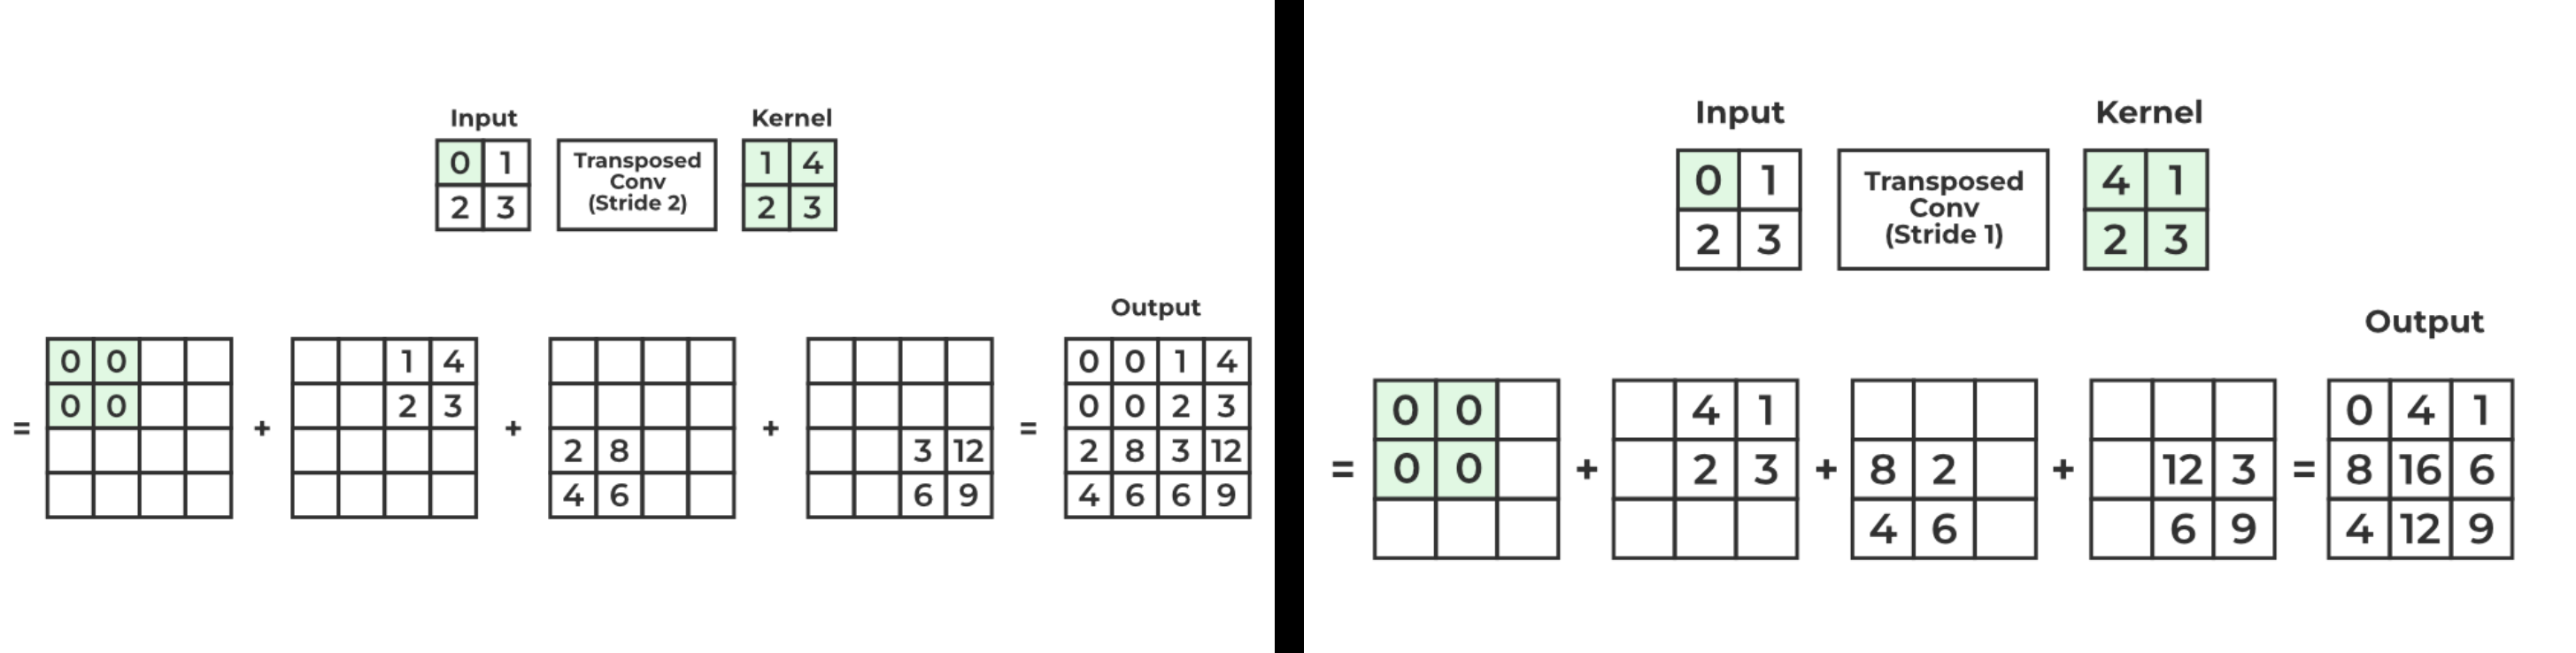

In [198]:
Image("imgs/tconv.png", width=11000)

[Source](https://www.geeksforgeeks.org/what-is-transposed-convolutional-layer/)

#### Implementing Conv-TasNet

We'll need to define three modules: `Encoder`, `Decoder` and `SeparationModule`. These three will be encapsulated in a single class defining the full `ConvTasNet` architecture. The structure of our implementation will be based on the one presented [here](https://github.com/kaituoxu/Conv-TasNet/blob/master/src/conv_tasnet.py).

In [223]:
class Encoder(nn.Module):
    def __init__(self, L, N):
        """
        :param L: kernel/filter size
        :param N: number of kernels for Conv1d
        """
        super(Encoder, self).__init__()
        
        self.L, self.N = L, N
        self.conv1d = nn.Conv1d(1, N, kernel_size=L, stride=L // 2, bias=False)
        self.relu = nn.ReLU()

    def forward(self, mixture):
        """
        :param mixture: torch.Tensor of shape (B, T), where B is the batch size and T the n.o. samples
        :returns: torch.Tensor of shape (B, N, K), where K is the new time dimension 
        """
        mixture = torch.unsqueeze(mixture, 1)  # (B, 1, T)
        mixture_w = self.relu(self.conv1d(mixture))  # (B, N, K)
        return mixture_w

As stated above, the encoder is represented by a single Conv1d layer followed by ReLU, acting on the input mixture signal.

In [242]:
import importlib
import convtasnet_utils
importlib.reload(convtasnet_utils)


class Decoder(nn.Module):
    def __init__(self, N, L):
        """
        :param N: same as Encoder
        :param L: same as Encoder
        """
        super(Decoder, self).__init__()
        
        self.N, self.L = N, L
        self.basis_signals = nn.Linear(N, L, bias=False)

    def forward(self, mixture_w, est_mask):
        """
        :param mixture_w: torch.Tensor of shape (B, N, K) - the output of Encoder
        :param est_mask: torch.Tensor of shape (B, C, N, K), where C is the number of sources
        :returns: torch.Tensor of shape (B, C, T) - the estimated sources, with same length as input mixture
        """

        source_w = torch.unsqueeze(mixture_w, 1) * est_mask  # (B, C, N, K)
        source_w = torch.transpose(source_w, 2, 3) # (B, C, K, N)

        est_source = self.basis_signals(source_w)  # (B, C, K, L)
        est_source = convtasnet_utils.overlap_and_add(est_source, self.L//2) # (B, C, T)
        
        return est_source

The sources are estimated segment-wise, that is, the mixture is first split into segments, then for each segment a mask is estimated and applied. The output adds (with an overlap corresponding to the kernel size and stride $L$ used by the `Encoder`) the masked segments. In the above code, there are $K$ frames of length $L$ which need to be added with an overlap of $50\%$ (`self.L//2`).

In [243]:
importlib.reload(convtasnet_utils)
from convtasnet_utils import TemporalBlock

class TemporalConvNet(nn.Module):
    def __init__(self, N, B, H, P, X, R, C, norm_type="gLN", causal=False,
                 mask_nonlinear='relu'):
        """
        Args:
            N: Number of filters in autoencoder
            B: Number of channels in bottleneck 1 × 1-conv block
            H: Number of channels in 1-D convolutional blocks
            P: Kernel size in convolutional blocks
            X: Number of convolutional blocks in each repeat
            R: Number of repeats
            C: Number of speakers
            norm_type: BN, gLN, cLN
            causal: causal or non-causal
            mask_nonlinear: use which non-linear function to generate mask
        """
        super(TemporalConvNet, self).__init__()

        self.C = C
        self.mask_nonlinear = mask_nonlinear

        layer_norm = nn.LayerNorm(N)  # <- LN acts on the last dimension, but we have (B, N, K) -> we need to transpose, then re-transpose
        bottleneck_conv1x1 = nn.Conv1d(N, B, 1, bias=False)

        repeats = []
        for r in range(R):
            blocks = []
            for x in range(X):
                dilation = 2**x
                padding = (P - 1) * dilation if causal else (P - 1) * dilation // 2
                blocks += [TemporalBlock(B, H, P, stride=1,
                                                         padding=padding,
                                                         dilation=dilation,
                                                         norm_type=norm_type,
                                                         causal=causal)]
            repeats += [nn.Sequential(*blocks)]
        temporal_conv_net = nn.Sequential(*repeats)
        # [M, B, K] -> [M, C*N, K]
        mask_conv1x1 = nn.Conv1d(B, C*N, 1, bias=False)
        # Put together
        self.network = nn.Sequential(layer_norm,
                                     bottleneck_conv1x1,
                                     temporal_conv_net,
                                     mask_conv1x1)

    def forward(self, mixture_w):
        """
        Keep this API same with TasNet
        Args:
            mixture_w: [M, N, K], M is batch size
        returns:
            est_mask: [M, C, N, K]

        :param 
        """
        M, N, K = mixture_w.size()
        score = self.network(mixture_w)  # [M, N, K] -> [M, C*N, K]
        score = score.view(M, self.C, N, K) # [M, C*N, K] -> [M, C, N, K]
        if self.mask_nonlinear == 'softmax':
            est_mask = F.softmax(score, dim=1)
        elif self.mask_nonlinear == 'relu':
            est_mask = F.relu(score)
        else:
            raise ValueError("Unsupported mask non-linear function")
        return est_mask

ImportError: cannot import name 'TemporalBlock' from 'convtasnet_utils' (C:\Users\lenovo\Desktop\IA2\L3\convtasnet_utils.py)

**Combining all modules:**

In [239]:
class ConvTasNet(nn.Module):
    def __init__(self, N, L, B, H, P, X, R, C, norm_type="gLN", causal=False,
                 mask_nonlinear='relu'):
        """
        Args:
            N: Number of filters in autoencoder
            L: Length of the filters (in samples)
            B: Number of channels in bottleneck 1 × 1-conv block
            H: Number of channels in convolutional blocks
            P: Kernel size in convolutional blocks
            X: Number of convolutional blocks in each repeat
            R: Number of repeats
            C: Number of speakers
            norm_type: BN, gLN, cLN
            causal: causal or non-causal
            mask_nonlinear: use which non-linear function to generate mask
        """
        super(ConvTasNet, self).__init__()

        self.N, self.L, self.B, self.H, self.P, self.X, self.R, self.C = N, L, B, H, P, X, R, C
        self.norm_type = norm_type
        self.causal = causal
        self.mask_nonlinear = mask_nonlinear
        self.encoder = Encoder(L, N)
        self.separator = TemporalConvNet(N, B, H, P, X, R, C, norm_type, causal, mask_nonlinear)
        self.decoder = Decoder(N, L)
        # init
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_normal_(p)

    def forward(self, mixture):
        """
        :param mixture: torch.Tensor of shape (B, T) where B is the batch size and T the time length
        """
        mixture_w = self.encoder(mixture)
        est_mask = self.separator(mixture_w)
        est_source = self.decoder(mixture_w, est_mask)

        # T changed after conv1d in encoder, fix it here
        T_origin = mixture.size(-1)
        T_conv = est_source.size(-1)
        est_source = F.pad(est_source, (0, T_origin - T_conv))
        return est_source

In [240]:
M, N, L, T = 2, 3, 4, 12
K = 2*T//L-1
B, H, P, X, R, C, norm_type, causal = 2, 3, 3, 3, 2, 2, "gLN", False

conv_tasnet = ConvTasNet(N, L, B, H, P, X, R, C, norm_type=norm_type)
mixture = torch.randint(3, (M, T))
est_source = conv_tasnet(mixture)
print('est_source', est_source)
print('est_source size', est_source.size())

AttributeError: module 'convtasnet_utils' has no attribute 'TemporalBlock'

### Other CNN Applications

- [Deep Convolutional GAN for synthetic faces generation ](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/5f81194dd43910d586578638f83205a3/dcgan_faces_tutorial.ipynb)
- [Training a CNN to play Mario using Reinforcement Learning](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/c195adbae0504b6504c93e0fd18235ce/mario_rl_tutorial.ipynb#scrollTo=kFptwCelNn1V)
- [Image Super-Resolution](https://debuggercafe.com/image-super-resolution-using-srcnn-and-pytorch/)
- [Creating Adversarial Examples by attacking CNNs](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/56c122e1c18e5e07666673e900acaed5/fgsm_tutorial.ipynb)